In [1]:
from WindPy import w
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
import seaborn as sns
%matplotlib inline

In [2]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!
You can use w.menu to help yourself to create commands(WSD,WSS,WST,WSI,WSQ,...)!

COPYRIGHT (C) 2016 WIND HONGHUI INFORMATION & TECHKNOLEWDGE CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [3]:
def wind2df(raw_data):
    dic = {}
    for data, field in zip(raw_data.Data, raw_data.Fields):
        dic[str(field.lower())] = data
    return pd.DataFrame(dic, index=raw_data.Times)

In [15]:
DATA_DIR = 'D:/Data/stocks'
INDEX_COMP_DIR = 'D:/Data/index-component'
index = '000016'
ticker = '000402.SZ'
fname = '%s/%s.xlsx'%(DATA_DIR, ticker)

In [16]:
df = pd.read_excel(fname, index_col=0)

In [17]:
df.head()

,amt,close,dealnum,free_turn,high,low,mfd_buyamt_a,mfd_sellamt_a,mkt_freeshares,turnover,volume,vwap
2015-01-05 00:00:00.005,2.290106e+09,11.449030,71026,8.581503,12.551529,11.449030,202753434.0,307754891.0,2.568462e+10,0.089163,181409558.0,11.895640
2015-01-06 00:00:00.005,1.506576e+09,10.751723,57236,6.222206,11.307684,10.412492,116244158.0,215909811.0,2.412029e+10,0.062461,131534957.0,10.793005
2015-01-07 00:00:00.005,7.360202e+08,10.676338,31869,3.090137,10.817684,10.440762,24246997.0,68144981.0,2.395117e+10,0.030730,65324265.0,10.617141
2015-01-08 00:00:00.005,7.290254e+08,10.271146,33209,3.121742,10.817684,10.252300,23812338.0,92433673.0,2.304217e+10,0.031639,65992377.0,10.409775
2015-01-09 00:00:00.005,8.447881e+08,10.271146,34405,3.600042,10.742300,10.110954,95653791.0,58500408.0,2.304217e+10,0.036663,76103462.0,10.460100


In [18]:
df['date'] = df.index

# Amihud(2002)的非流动性比率
单位成交额的收益率

In [19]:
df['return'] = df['close'].pct_change()

In [20]:
df['amihud'] = np.abs(df['return']) * 10e6 / (df['volume'] * df['close'])

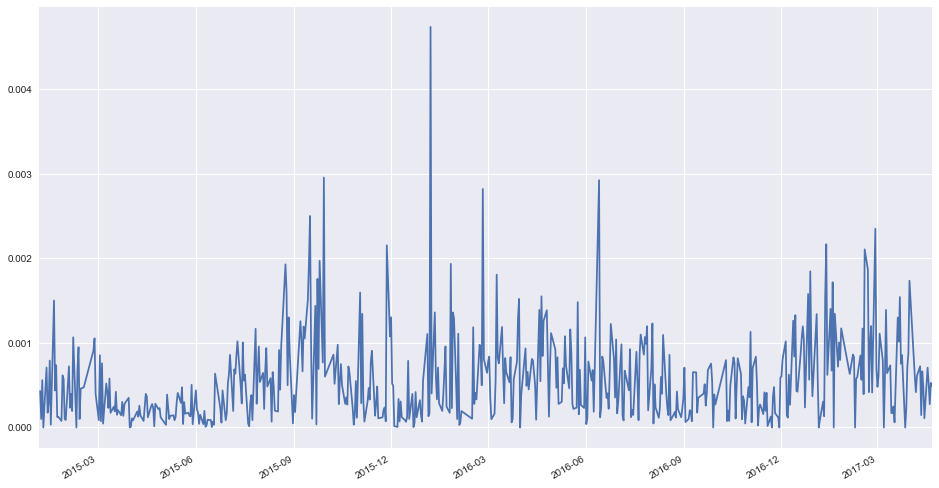

In [21]:
plt.figure(figsize=(16, 9))
df['amihud'].plot()

# 吴冲锋(2003)
单位换手率的收益率

In [22]:
df['turn'] = df['amt'] / df['mkt_freeshares']

In [23]:
df['wu'] = np.abs(df['return']) / df['turn']

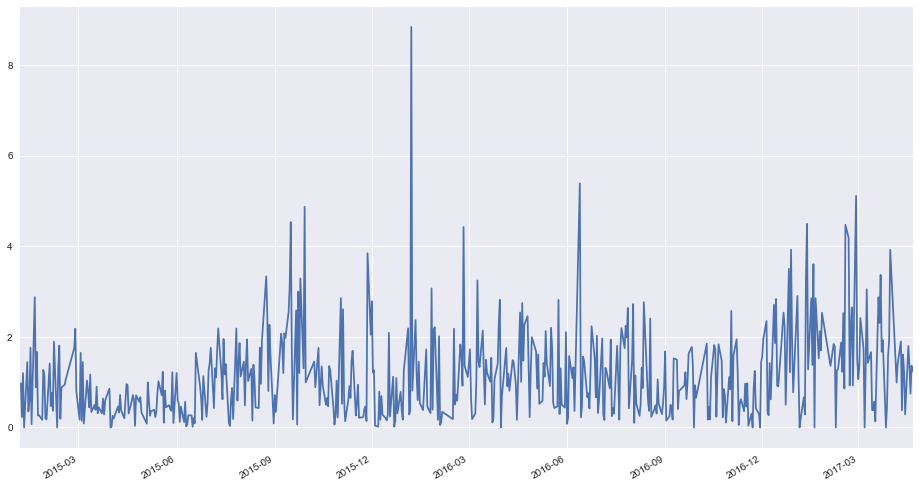

In [24]:
plt.figure(figsize=(16, 9))
df['wu'].plot()

# 全市场流动性

In [25]:
index = '000300'
ind_df = pd.read_excel('%s/%s.xlsx'%(INDEX_COMP_DIR, index))

In [26]:
dic = {}
for ticker in ind_df['code']:
    fname = '%s/%s.xlsx'%(DATA_DIR, ticker)
    df = pd.read_excel(fname, index_col=0)
    df['turn'] = df['amt'] / df['mkt_freeshares']
    df['ret'] = df['close'].pct_change()
    dic[ticker] = df[['amt', 'volume', 'ret', 'close', 'turn']]
pnl = pd.Panel(dic)

In [29]:
pnl.ix[:, :, 'amihud'] = pnl.minor_xs('ret').abs() * 10e6 / (pnl.minor_xs('volume') * pnl.minor_xs('close'))

In [30]:
pnl.ix[:, :, 'amihud'] = pnl.minor_xs('amihud').replace(np.inf, np.nan)

2015-06-01 00:00:00.005    0.080785
2015-06-02 00:00:00.005    0.067741
2015-05-28 00:00:00.005    0.063223
2015-08-14 00:00:00.005    0.050580
2015-05-29 00:00:00.005    0.050526
2015-06-03 00:00:00.005    0.036610
2015-04-07 00:00:00.005    0.026130
2015-08-13 00:00:00.005    0.021957
2015-01-23 00:00:00.005    0.021899
2015-01-26 00:00:00.005    0.020642
2016-06-16 00:00:00.005    0.019998
2015-06-05 00:00:00.005    0.016790
2015-01-27 00:00:00.005    0.015673
2015-05-08 00:00:00.005    0.015227
2016-06-17 00:00:00.005    0.014288
2015-04-08 00:00:00.005    0.011485
2015-03-18 00:00:00.005    0.011366
2016-06-20 00:00:00.005    0.010459
2016-01-07 00:00:00.005    0.010249
2015-06-08 00:00:00.005    0.009936
dtype: float64


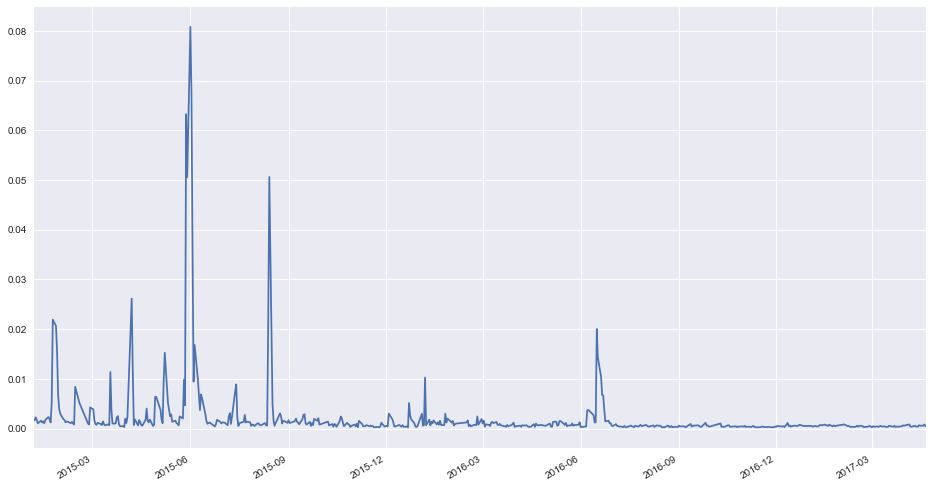

In [31]:
plt.figure(figsize=(16, 9))
print pnl.minor_xs('amihud').mean(axis=1).nlargest(20)
pnl.minor_xs('amihud').mean(axis=1).plot()
# pnl.minor_xs('amihud').mean(axis=1).rolling(window=5).sum().plot()

In [32]:
pnl.ix[:, :, 'wu'] = pnl.minor_xs('ret').abs() / pnl.minor_xs('turn')

In [33]:
pnl.ix[:, :, 'wu'] = pnl.minor_xs('wu').replace(np.inf, np.nan)

2016-01-07 00:00:00.005    14.252897
2015-05-26 00:00:00.005    10.258564
2015-08-14 00:00:00.005     9.184766
2015-06-02 00:00:00.005     8.403356
2015-06-01 00:00:00.005     8.037557
2015-07-14 00:00:00.005     6.304692
2015-05-28 00:00:00.005     5.222464
2015-06-12 00:00:00.005     5.150845
2015-06-11 00:00:00.005     5.094437
2015-07-13 00:00:00.005     5.075018
2015-06-03 00:00:00.005     4.712018
2015-05-08 00:00:00.005     4.419962
2016-01-04 00:00:00.005     4.379513
2015-05-29 00:00:00.005     4.258222
2015-05-27 00:00:00.005     4.030956
2015-12-23 00:00:00.005     3.956055
2015-08-13 00:00:00.005     3.933780
2016-06-16 00:00:00.005     3.834795
2016-01-26 00:00:00.005     3.713255
2015-03-25 00:00:00.005     3.644540
dtype: float64


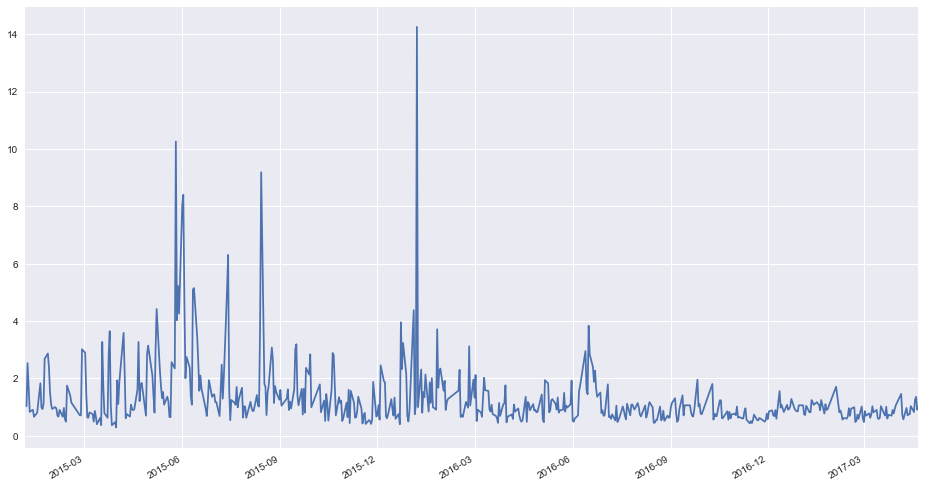

In [34]:
plt.figure(figsize=(16, 9))
print pnl.minor_xs('wu').mean(axis=1).nlargest(20)
pnl.minor_xs('wu').mean(axis=1).plot()
# pnl.minor_xs('wu').mean(axis=1).rolling(window=5).sum().plot()

# A Simple Way to Estimate Bid-Ask Spreads from Daily High and Low Prices

$$\beta = \sum_{j=0}^1 \left(ln(\frac{H_{t+j}^O}{L_{t+j}^O})\right)^2$$
$$\gamma = \left(ln(\frac{H_{t,t+1}^O}{L_{t,t+1}^O}) \right)^2$$
$$\alpha = \frac{\sqrt{2\beta}-\sqrt{\beta}}{3-2\sqrt{2}} - \sqrt{\frac{\gamma}{3-2\sqrt{2}}}$$
$$S = \frac{2(e^{\alpha}-1)}{1+e^{\alpha}}$$

In [109]:
df = pd.read_excel('%s/000402.SZ.xlsx'%(DATA_DIR), index_col=0)

In [110]:
df.tail()

,amt,close,dealnum,free_turn,high,low,mfd_buyamt_a,mfd_sellamt_a,mkt_freeshares,turnover,volume,vwap
2017-04-17 00:00:00.005,541304025.0,12.58,23852,2.119120,13.12,12.36,35667200.0,101474665.0,2.545860e+10,0.021262,42885405.0,12.622104
2017-04-18 00:00:00.005,608344001.0,12.98,23962,2.327022,13.30,12.48,100202139.0,40189638.0,2.626810e+10,0.023159,47092782.0,12.917988
2017-04-19 00:00:00.005,830507683.0,13.28,25722,3.124690,13.48,12.78,140220053.0,99176480.0,2.687522e+10,0.030902,63235487.0,13.133570
2017-04-20 00:00:00.005,590728101.0,12.87,19314,2.248615,13.34,12.70,25114359.0,101438382.0,2.604549e+10,0.022681,45506032.0,12.981314
2017-04-21 00:00:00.005,400814978.0,12.62,13691,1.544621,12.98,12.57,21932289.0,48881087.0,2.553955e+10,0.015694,31259059.0,12.822362


In [111]:
df['high t-1'] = df['high'].shift(1)
df['low t-1'] = df['low'].shift(1)

In [112]:
df.head()

,amt,close,dealnum,free_turn,high,low,mfd_buyamt_a,mfd_sellamt_a,mkt_freeshares,turnover,volume,vwap,high t-1,low t-1
2015-01-05 00:00:00.005,2.290106e+09,11.449030,71026,8.581503,12.551529,11.449030,202753434.0,307754891.0,2.568462e+10,0.089163,181409558.0,11.895640,NaN,NaN
2015-01-06 00:00:00.005,1.506576e+09,10.751723,57236,6.222206,11.307684,10.412492,116244158.0,215909811.0,2.412029e+10,0.062461,131534957.0,10.793005,12.551529,11.449030
2015-01-07 00:00:00.005,7.360202e+08,10.676338,31869,3.090137,10.817684,10.440762,24246997.0,68144981.0,2.395117e+10,0.030730,65324265.0,10.617141,11.307684,10.412492
2015-01-08 00:00:00.005,7.290254e+08,10.271146,33209,3.121742,10.817684,10.252300,23812338.0,92433673.0,2.304217e+10,0.031639,65992377.0,10.409775,10.817684,10.440762
2015-01-09 00:00:00.005,8.447881e+08,10.271146,34405,3.600042,10.742300,10.110954,95653791.0,58500408.0,2.304217e+10,0.036663,76103462.0,10.460100,10.817684,10.252300


In [113]:
df.tail()

,amt,close,dealnum,free_turn,high,low,mfd_buyamt_a,mfd_sellamt_a,mkt_freeshares,turnover,volume,vwap,high t-1,low t-1
2017-04-17 00:00:00.005,541304025.0,12.58,23852,2.119120,13.12,12.36,35667200.0,101474665.0,2.545860e+10,0.021262,42885405.0,12.622104,13.55,12.75
2017-04-18 00:00:00.005,608344001.0,12.98,23962,2.327022,13.30,12.48,100202139.0,40189638.0,2.626810e+10,0.023159,47092782.0,12.917988,13.12,12.36
2017-04-19 00:00:00.005,830507683.0,13.28,25722,3.124690,13.48,12.78,140220053.0,99176480.0,2.687522e+10,0.030902,63235487.0,13.133570,13.30,12.48
2017-04-20 00:00:00.005,590728101.0,12.87,19314,2.248615,13.34,12.70,25114359.0,101438382.0,2.604549e+10,0.022681,45506032.0,12.981314,13.48,12.78
2017-04-21 00:00:00.005,400814978.0,12.62,13691,1.544621,12.98,12.57,21932289.0,48881087.0,2.553955e+10,0.015694,31259059.0,12.822362,13.34,12.70


In [114]:
df['beta'] = np.log(df['high']/df['low'])**2 + np.log(df['high t-1']/df['low t-1'])**2

In [115]:
df['gamma'] = np.log(df[['high', 'high t-1']].max(axis=1) / df[['low', 'low t-1']].min(axis=1))**2

In [116]:
df['alpha'] = (np.sqrt(2*df['beta'])-np.sqrt(df['beta']))/(3-2*np.sqrt(2)) - np.sqrt((df['gamma'])/(3-2*np.sqrt(2)))

In [117]:
df['S'] = 2*(np.exp(df['alpha'])-1)/(1+np.exp(df['alpha']))

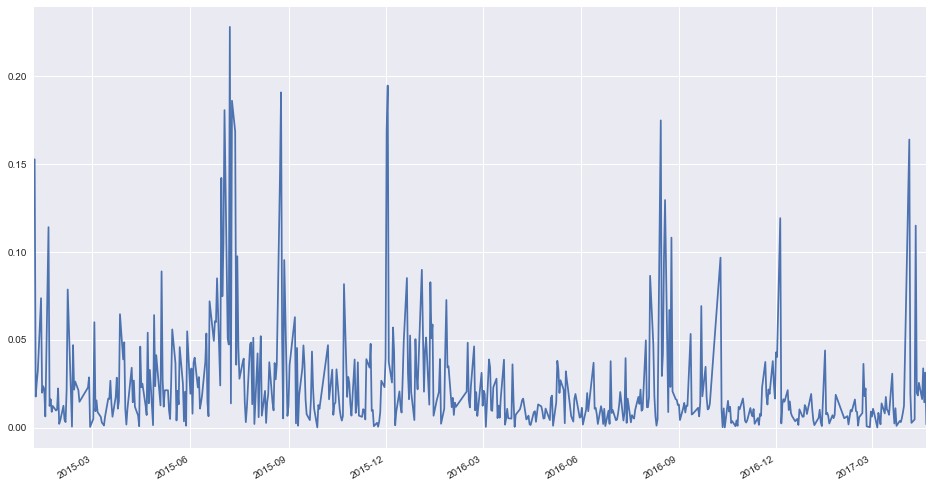

In [118]:
plt.figure(figsize=(16, 9))
df['S'].abs().plot()

In [71]:
k = 20
df['ret'] = df['close'].pct_change(k).shift(-k)

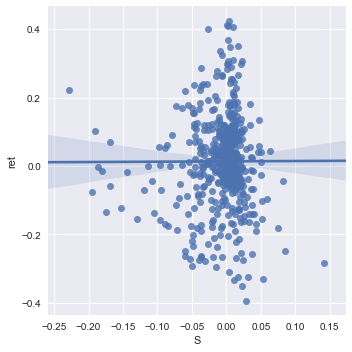

In [72]:
sns.lmplot(x='S', y='ret', data=df)

### 全市场

In [78]:
dic = {}
for ticker in ind_df['code']:
    fname = '%s/%s.xlsx'%(DATA_DIR, ticker)
    df = pd.read_excel(fname, index_col=0)
    df['turn'] = df['amt'] / df['mkt_freeshares']
    df['ret'] = df['close'].pct_change()
    dic[ticker] = df[['amt', 'volume', 'ret', 'close', 'turn', 'high', 'low']]
pnl = pd.Panel(dic)

In [149]:
# df['beta'] = np.log(df['high']/df['low'])**2 + np.log(df['high t-1']/df['low t-1'])**2
pnl.ix[:, :, 'high t-1'] = pnl.minor_xs('high').shift(1)
pnl.ix[:, :, 'low t-1'] = pnl.minor_xs('low').shift(1)
pnl.ix[:, :, 'beta'] = np.log(pnl.minor_xs('high') / pnl.minor_xs('low'))**2 + np.log(pnl.minor_xs('high t-1') / pnl.minor_xs('low t-1'))**2

In [150]:
# df['gamma'] = np.log(df[['high', 'high t-1']].max(axis=1) / df[['low', 'low t-1']].min(axis=1))**2
pnl.ix[:, :, 'gamma'] = np.log(pnl.ix[:, :, ['high', 'high t-1']].max(axis=2) / pnl.ix[:, :, ['low', 'low t-1']].min(axis=2))**2

In [151]:
# df['alpha'] = (np.sqrt(2*df['beta'])-np.sqrt(df['beta']))/(3-2*np.sqrt(2)) - np.sqrt((df['gamma'])/(3-2*np.sqrt(2)))
pnl.ix[:, :, 'alpha'] = (np.sqrt(2*pnl.minor_xs('beta'))-np.sqrt(pnl.minor_xs('beta')))/(3-2*np.sqrt(2)) - np.sqrt(pnl.minor_xs('gamma')/(3-2*np.sqrt(2)))

In [152]:
# df['S'] = 2*(np.exp(df['alpha'])-1)/(1+np.exp(df['alpha']))
pnl.ix[:, :, 'S'] = 2*(np.exp(pnl.minor_xs('alpha'))-1) / (1+np.exp(pnl.minor_xs('alpha')))

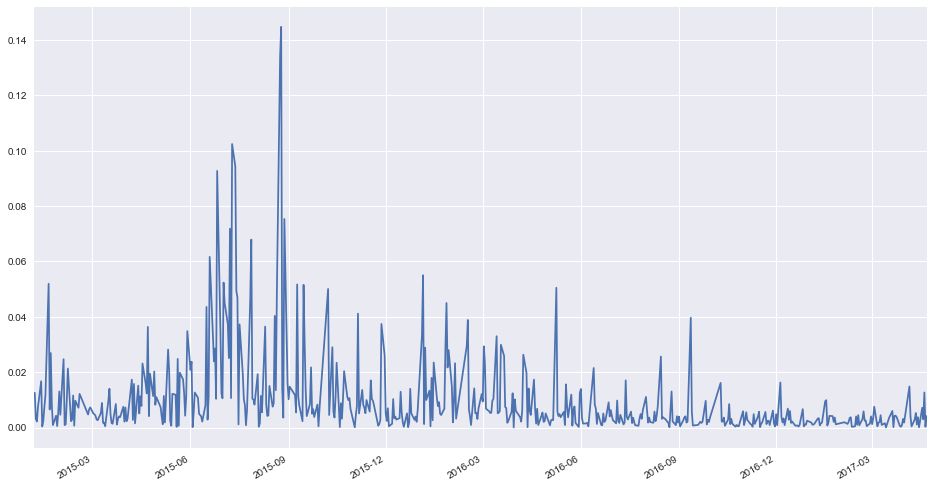

In [153]:
plt.figure(figsize=(16, 9))
pnl.minor_xs('S').mean(axis=1).abs().plot()

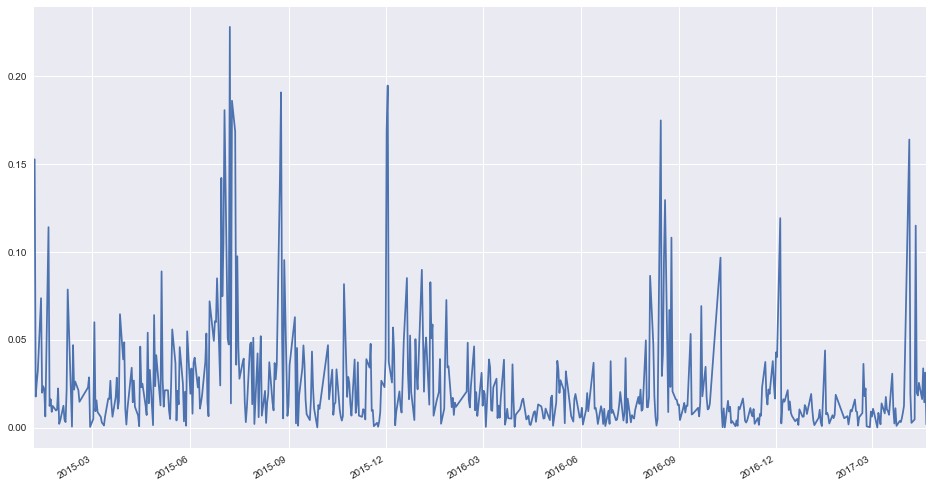

In [154]:
plt.figure(figsize=(16, 9))
pnl['000402.SZ']['S'].abs().plot()

# Roll Model

In [156]:
df['ret_1'] = df['close'].diff()
df['ret_2'] = df['ret_1'].shift(1)

In [157]:
df['roll'] = df['ret_1'].rolling(window=60).cov(df['ret_2'])

In [158]:
df['roll'] = 2 * np.sqrt(df['roll'].abs())

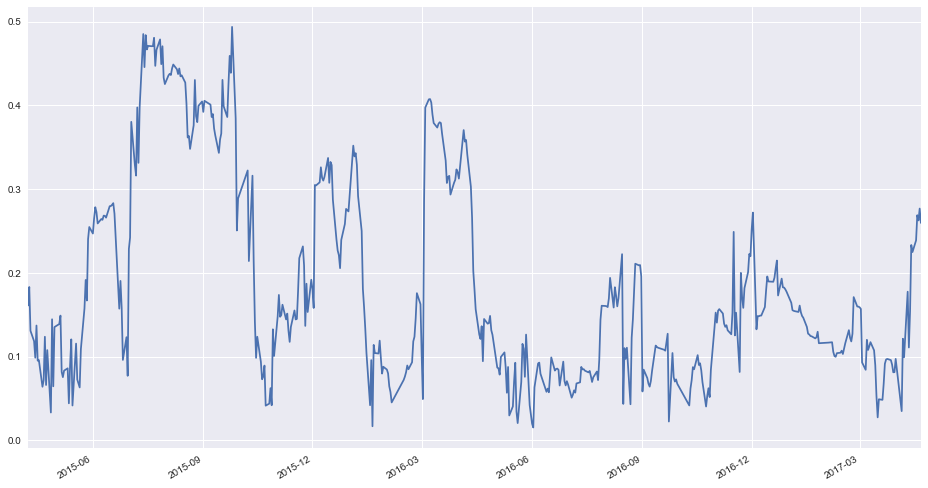

In [160]:
plt.figure(figsize=(16, 9))
df['roll'].dropna().plot()